In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd ./drive/MyDrive/Colab\ Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt#; plt.rcParams['figure.dpi'] = 200

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print("Loading MNIST dataset...")
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

Loading MNIST dataset...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# AE(Autoencoder)

## model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        z = torch.flatten(x, start_dim=1)
        z = F.relu(self.linear1(z))
        return self.linear2(z)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        x_hat = F.relu(self.linear1(z))
        x_hat = torch.sigmoid(self.linear2(x_hat))
        return x_hat.reshape((-1, 1, 28, 28))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## train

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}/{epochs}")
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
latent_dims = 2

In [ ]:
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder = train(autoencoder, data)

epoch: 1/20
epoch: 2/20
epoch: 3/20
epoch: 4/20
epoch: 5/20
epoch: 6/20
epoch: 7/20
epoch: 8/20
epoch: 9/20
epoch: 10/20
epoch: 11/20
epoch: 12/20
epoch: 13/20
epoch: 14/20
epoch: 15/20
epoch: 16/20
epoch: 17/20
epoch: 18/20
epoch: 19/20
epoch: 20/20


## plot

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

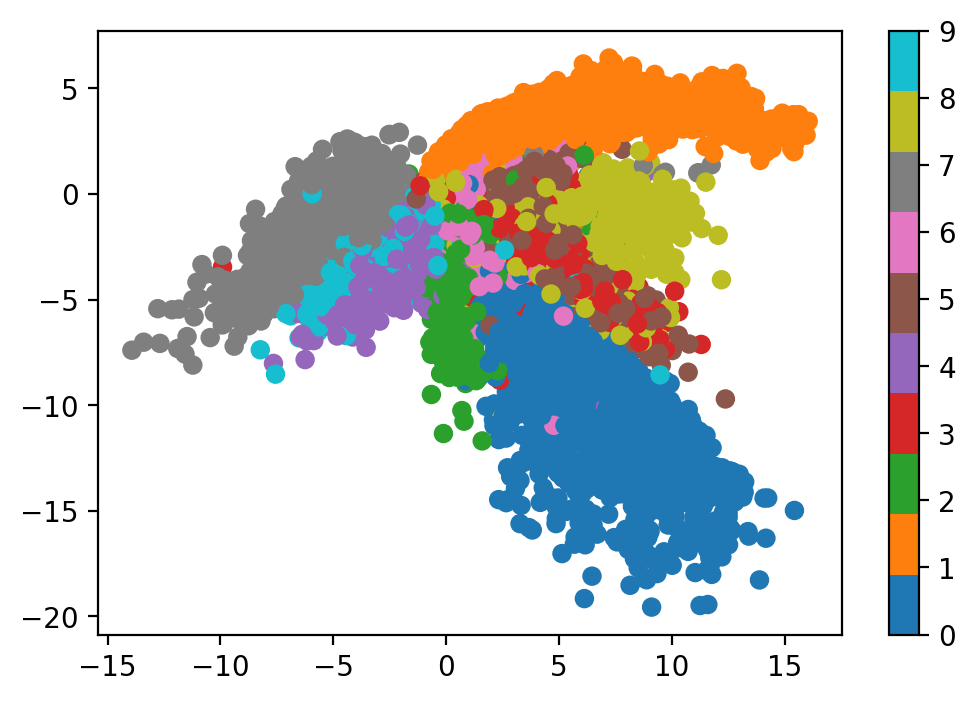

In [ ]:
plot_latent(autoencoder, data)

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

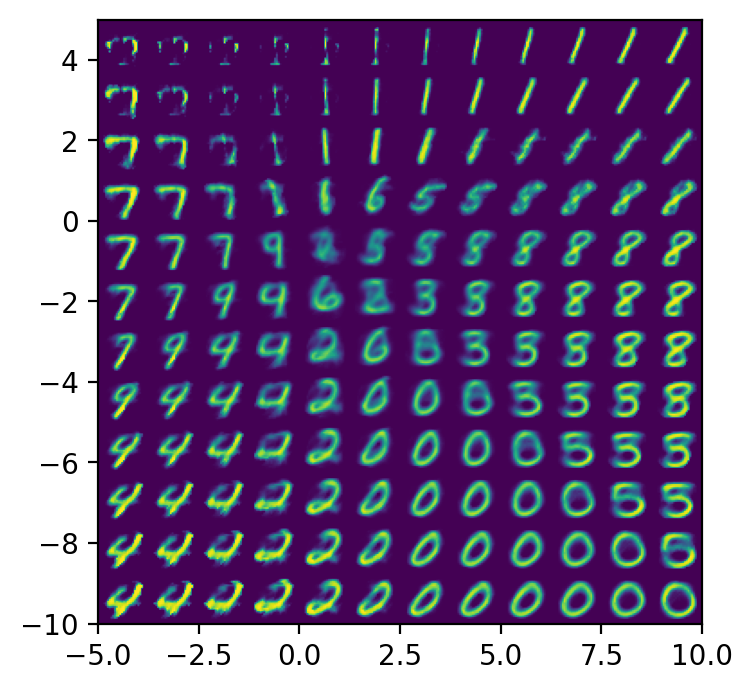

In [ ]:
plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12)

# VAE(Variational Autoencoder)

## model

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        
        z = mu + sigma*torch.randn_like(sigma)
        self.kl = 0.5*(sigma**2 + mu**2 - torch.log(sigma) - 1).sum()

        return z

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## train

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}/{epochs}")
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

epoch: 1/20
epoch: 2/20
epoch: 3/20
epoch: 4/20
epoch: 5/20
epoch: 6/20
epoch: 7/20
epoch: 8/20
epoch: 9/20
epoch: 10/20
epoch: 11/20
epoch: 12/20
epoch: 13/20
epoch: 14/20
epoch: 15/20
epoch: 16/20
epoch: 17/20
epoch: 18/20
epoch: 19/20
epoch: 20/20


## plot

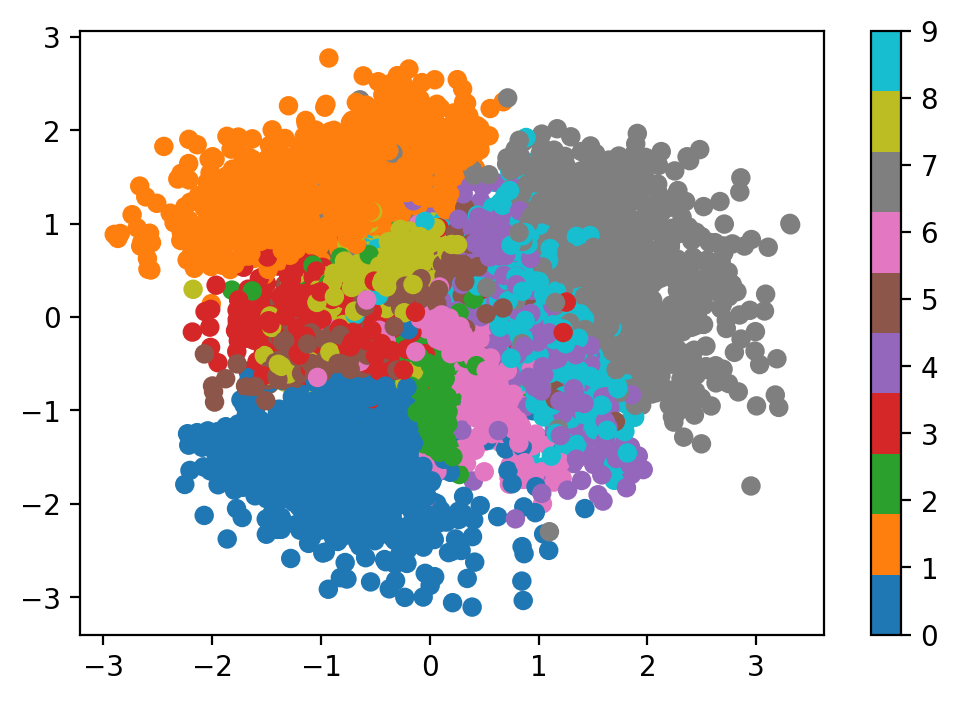

In [ ]:
plot_latent(vae, data)

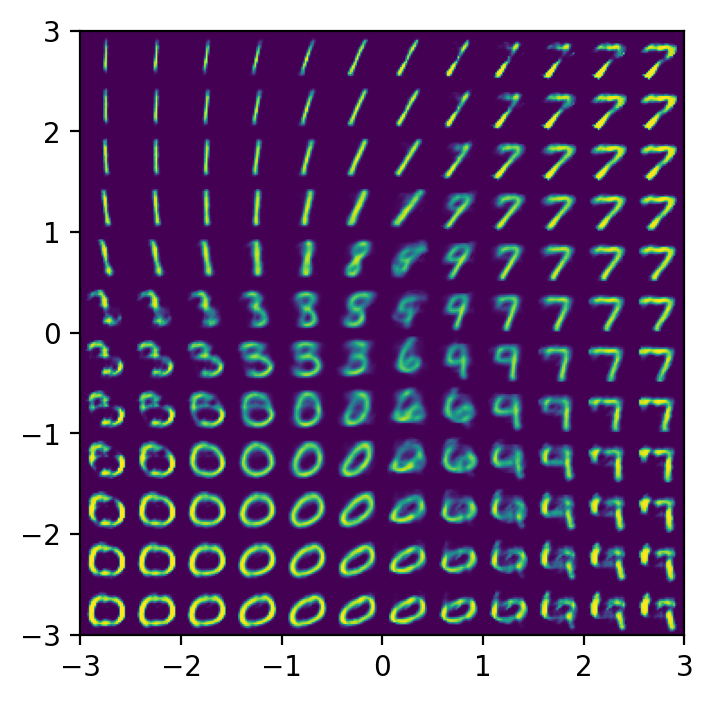

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3), n=12)

# Interpolation

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

([], <a list of 0 Text major ticklabel objects>)

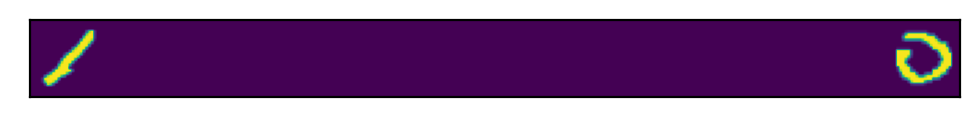

In [ ]:
w = 28
n = 12
img = np.zeros((w, 12*w))
img[:, :1*w] = x_1[0].cpu() # 1
img[:, (n-1)*w:n*w] = x_2[0].cpu() # 0
plt.imshow(img)
plt.xticks([])
plt.yticks([])

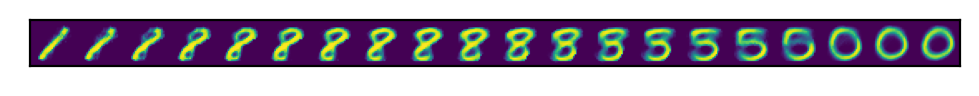

In [ ]:
interpolate(autoencoder, x_1, x_2, n=20)

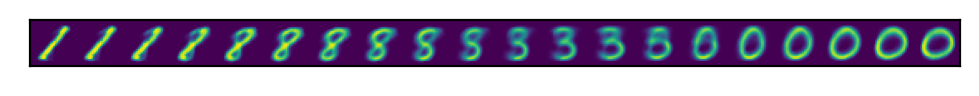

In [ ]:
interpolate(vae, x_1, x_2, n=20)

# VQ-VAE(Vector Quantised-Variational AutoEncoder)

## model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, pic_channels=1):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=pic_channels, out_channels=latent_dims//2, kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels=latent_dims//2, out_channels=latent_dims, kernel_size=4)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        #print(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, pic_channels=1):
        super(Decoder, self).__init__()
        self.conv_trans1 = nn.ConvTranspose2d(in_channels=latent_dims, out_channels=latent_dims//2, kernel_size=4)
        self.conv_trans2 = nn.ConvTranspose2d(in_channels=latent_dims//2, out_channels=pic_channels, kernel_size=4)

    def forward(self, x):
        x = self.conv_trans1(x)
        x = F.relu(x)
        x = self.conv_trans2(x)
        return x

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, latent_dims, num_codes=32, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_codes
        self.D = latent_dims
        self.beta = beta

        self.codebook = nn.Embedding(self.K, self.D)
        self.codebook.weight.data.uniform_(-1 / self.K, 1 / self.K)

        self.vq_loss = 0

    def forward(self, latents):
        '''
         latents: (batch, dim, height, width)
         codebook: (K, dim)
        '''
        # convert latents from BCHW -> BHWC
        latents = latents.permute(0, 2, 3, 1).contiguous() # (B, H, W, dim)
        latents_shape = latents.shape
        
        # Flatten latent
        flat_latent = latents.view(-1, self.D) # (BHW, dim)

        # Compute L2 distance between latents and codes in codebook
        dist = (flat_latent.unsqueeze(1) - self.codebook.weight.unsqueeze(0)) ** 2 # (BHW, 1, dim) - (1, K, dim) -> (BHW, K, dim)
        dist = dist.sum(-1) # (BHW, K)

        # Get the code index that has the min distance
        nearest_idxs = torch.argmin(dist, dim=1).unsqueeze(1)  # (BHW, 1)

        # Convert to one-hot
        nearest_one_hot = torch.zeros(nearest_idxs.size(0), self.K, device=latents.device) # (BHW, K)
        nearest_one_hot.scatter_(1, nearest_idxs, 1)  # .scatter(dim,index,src)

        # Quantize the latents
        quantized_latents = torch.matmul(nearest_one_hot, self.codebook.weight).view(latents_shape) # (BHW, K) * (K, dim) = (BHW, dim) -> (B, H, W, dim)

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        codebook_loss = F.mse_loss(quantized_latents, latents.detach())

        self.vq_loss = commitment_loss * self.beta + codebook_loss

        # convert quantized from BHWC -> BCHW
        quantized_latents = latents + (quantized_latents - latents).detach() # straight-through estimator
        return quantized_latents.permute(0, 3, 1, 2).contiguous()

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, latent_dims, num_codes=32, beta=0.25, gamma=0.99, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        self.K = num_codes
        self.D = latent_dims
        self.beta = beta
        self.gamma = gamma
        self.epsilon = 1e-5

        self.codebook = nn.Embedding(self.K, self.D)
        self.codebook.weight.data.normal_()

        self.N = None
        self.m = None

        self.vq_loss = 0

    def forward(self, latents):
        '''
         latents: (batch, dim, height, width)
         codebook: (K, dim)
        '''
        # convert latents from BCHW -> BHWC
        latents = latents.permute(0, 2, 3, 1).contiguous() # (B, H, W, dim)
        latents_shape = latents.shape
        
        # Flatten latent
        flat_latent = latents.view(-1, self.D) # (BHW, dim)

        # Compute L2 distance between latents and codes in codebook
        dist = (flat_latent.unsqueeze(1) - self.codebook.weight.unsqueeze(0)) ** 2 # (BHW, 1, dim) - (1, K, dim) -> (BHW, K, dim)
        dist = dist.sum(-1) # (BHW, K)

        # Get the code index that has the min distance
        nearest_idxs = torch.argmin(dist, dim=1).unsqueeze(1)  # (BHW, 1)

        # Convert to one-hot
        nearest_one_hot = torch.zeros(nearest_idxs.size(0), self.K, device=latents.device) # (BHW, K)
        nearest_one_hot.scatter_(1, nearest_idxs, 1)  # .scatter(dim,index,src)

        # Quantize the latents
        quantized_latents = torch.matmul(nearest_one_hot, self.codebook.weight).view(latents_shape) # (BHW, K) * (K, dim) = (BHW, dim) -> (B, H, W, dim)

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        self.vq_loss = commitment_loss * self.beta

        # EMA update cookbook
        n = torch.sum(nearest_one_hot, 0) # (K)
        self.N = self.N * self.gamma + (1 - self.gamma) * n if self.N is not None else n
        N_ = torch.sum(self.N.data) # Laplace smoothing of the cluster size
        self.N = (self.N + self.epsilon) / (N_ + self.K * self.epsilon) * N_
        z = torch.matmul(nearest_one_hot.T, flat_latent) # (K, BHW) * (BHW, dim) = (K, dim)
        self.m = nn.Parameter(self.m * self.gamma + (1 - self.gamma) * z) if self.m is not None else nn.Parameter(z)
        self.codebook.weight = nn.Parameter(self.m / self.N.unsqueeze(1))
        
        # convert quantized from BHWC -> BCHW
        quantized_latents = latents + (quantized_latents - latents).detach() # straight-through estimator
        return quantized_latents.permute(0, 3, 1, 2).contiguous()

In [ ]:
class VQVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, ema=True):
        super(VQVariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        if ema:
          self.vector_quantizer = VectorQuantizerEMA(latent_dims)
        else:
          self.vector_quantizer = VectorQuantizer(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z_e = self.encoder(x)
        z_q = self.vector_quantizer(z_e) # (batch, dim, 22, 22)
        return self.decoder(z_q)

## plot

In [ ]:
def plot_codebook(autoencoder):
    codes = autoencoder.vector_quantizer.codebook.weight.detach().cpu().numpy()
    for i in range(codes.shape[0]):
        plt.scatter(codes[i][0], codes[i][1])
    plt.show()

In [ ]:
def plot_recon(autoencoder, data, n=10):
    x = next(iter(data))[0][:n]
    x_hat = autoencoder(x.to(device))
    x_hat = x_hat.to('cpu').detach().numpy().squeeze(1)

    w = x_hat.shape[1]
    img = np.zeros((w, n*w))

    print("original:")
    for i in range(x_hat.shape[0]):
      img[:, i*w:(i+1)*w] = x[i]
    plt.imshow(img)
    plt.show()

    print("reconstructed:")
    for i in range(x_hat.shape[0]):
      img[:, i*w:(i+1)*w] = x_hat[i]
    plt.imshow(img)
    plt.show()

## train

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}/{epochs}")
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.vector_quantizer.vq_loss
            loss.backward()
            opt.step()
        plot_codebook(autoencoder)
        plot_recon(autoencoder, data)
    return autoencoder

### latent_dims=2, ema=False

epoch: 1/20


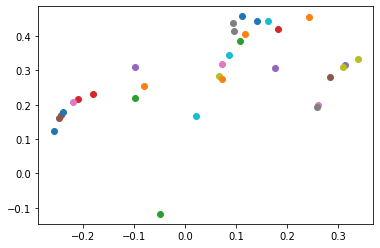

original:


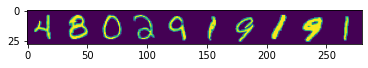

reconstructed:


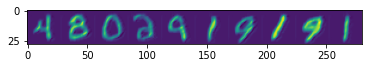

epoch: 2/20


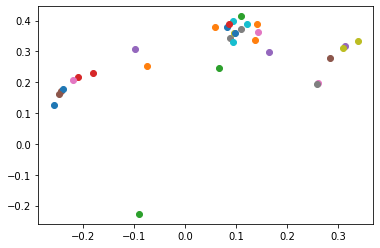

original:


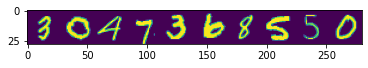

reconstructed:


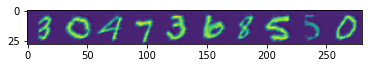

epoch: 3/20


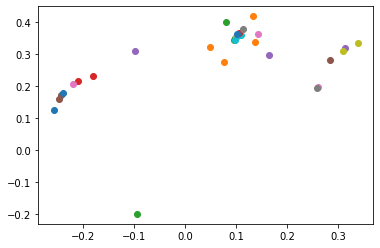

original:


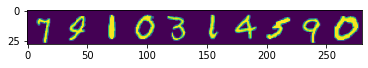

reconstructed:


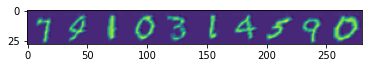

epoch: 4/20


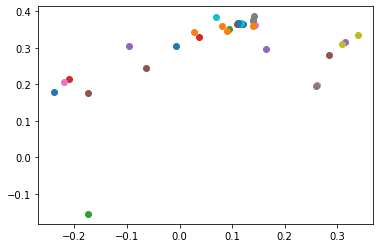

original:


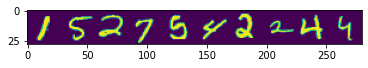

reconstructed:


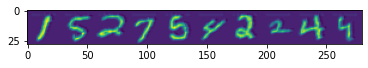

epoch: 5/20


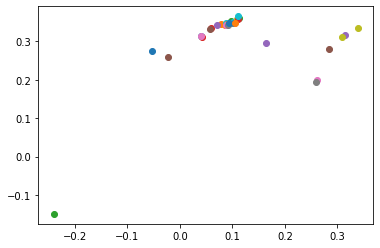

original:


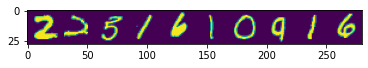

reconstructed:


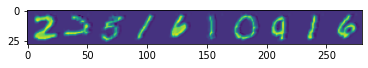

epoch: 6/20


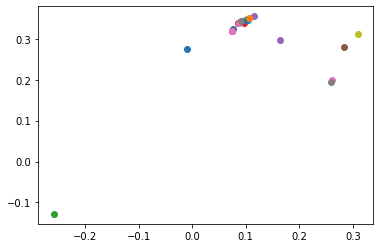

original:


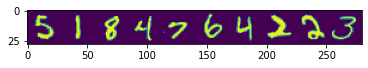

reconstructed:


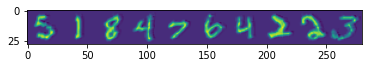

epoch: 7/20


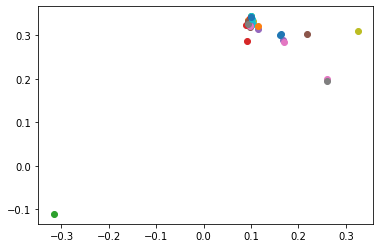

original:


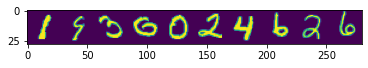

reconstructed:


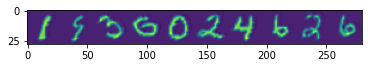

epoch: 8/20


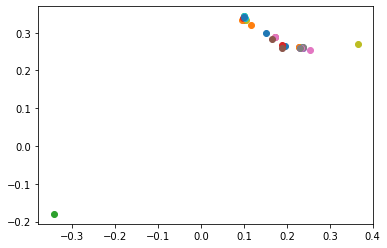

original:


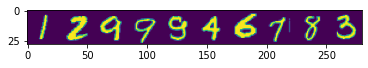

reconstructed:


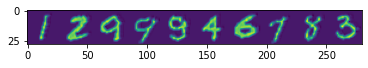

epoch: 9/20


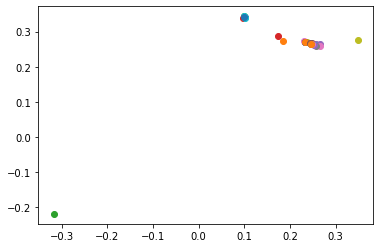

original:


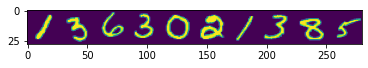

reconstructed:


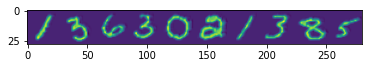

epoch: 10/20


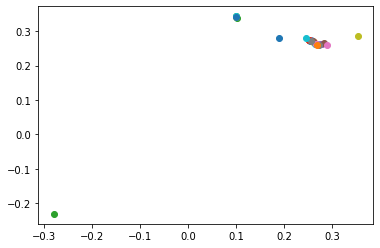

original:


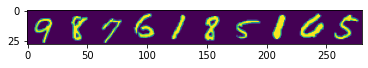

reconstructed:


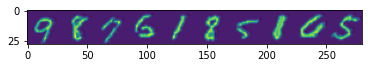

epoch: 11/20


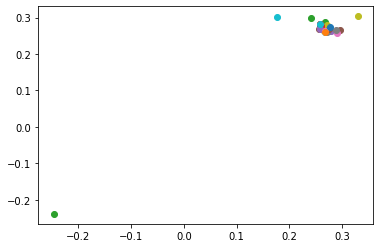

original:


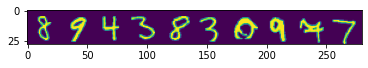

reconstructed:


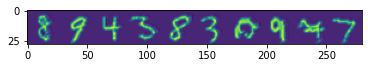

epoch: 12/20


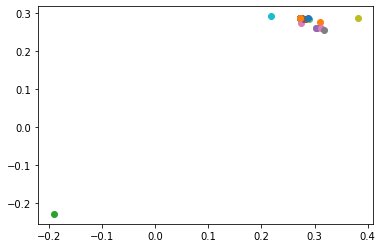

original:


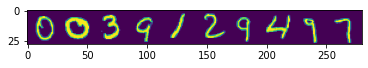

reconstructed:


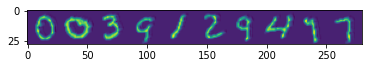

epoch: 13/20


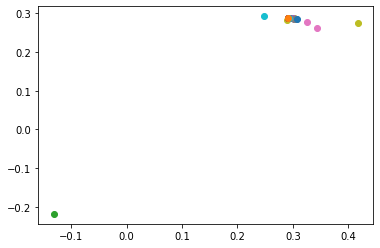

original:


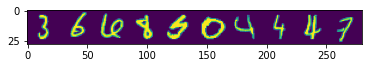

reconstructed:


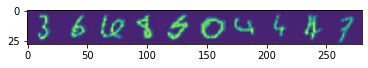

epoch: 14/20


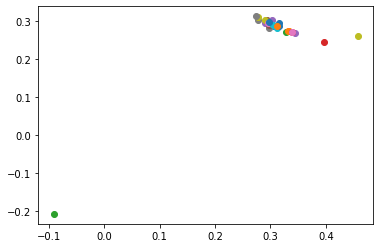

original:


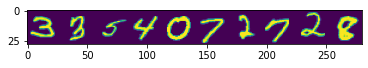

reconstructed:


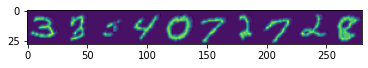

epoch: 15/20


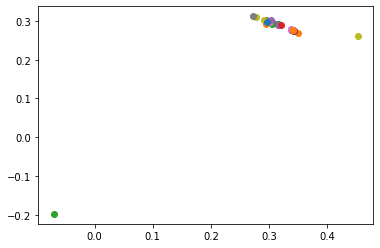

original:


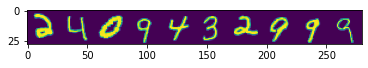

reconstructed:


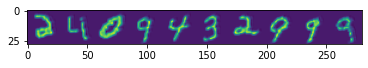

epoch: 16/20


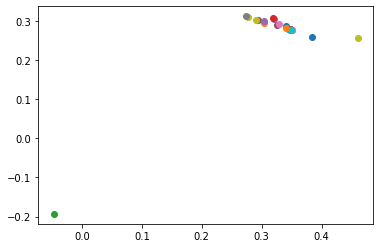

original:


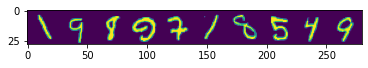

reconstructed:


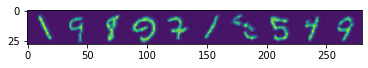

epoch: 17/20


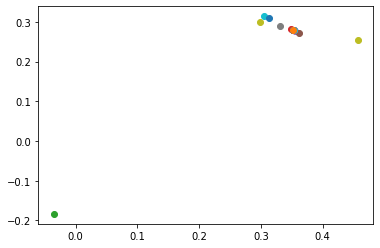

original:


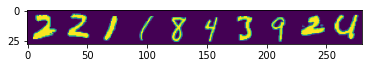

reconstructed:


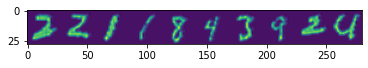

epoch: 18/20


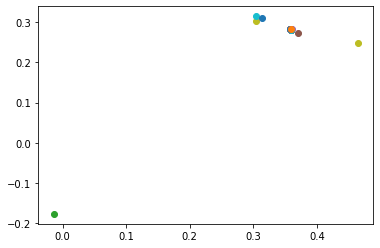

original:


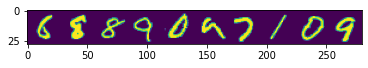

reconstructed:


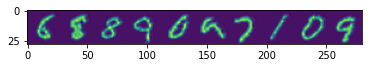

epoch: 19/20


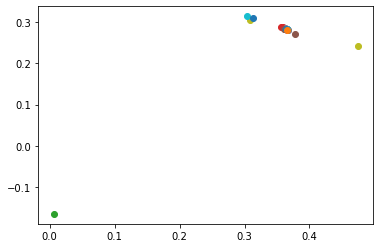

original:


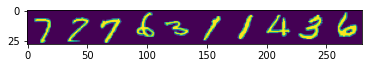

reconstructed:


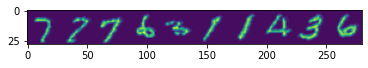

epoch: 20/20


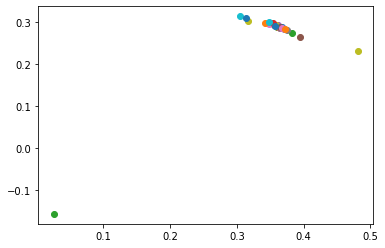

original:


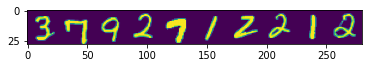

reconstructed:


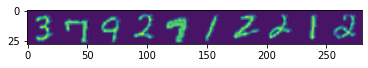

In [ ]:
vqvae = VQVariationalAutoencoder(latent_dims=2, ema=False).to(device) # GPU
vqvae = train(vqvae, data)

### latent_dims=2, ema=True

epoch: 1/20


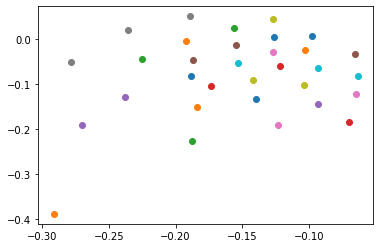

original:


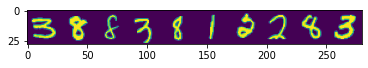

reconstructed:


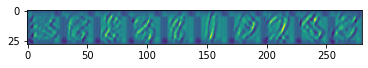

epoch: 2/20


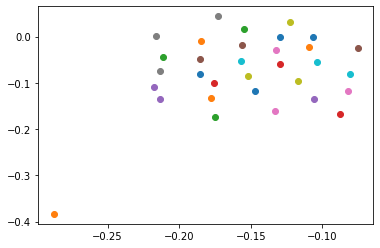

original:


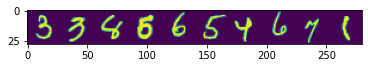

reconstructed:


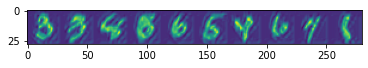

epoch: 3/20


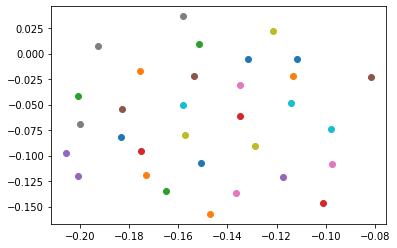

original:


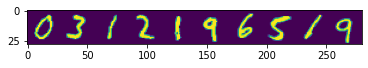

reconstructed:


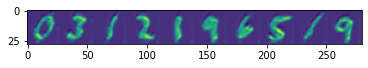

epoch: 4/20


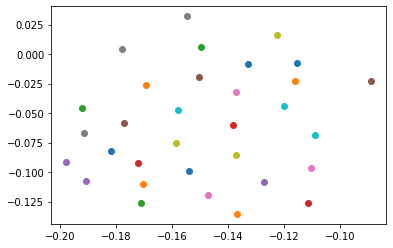

original:


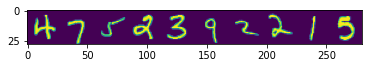

reconstructed:


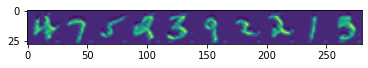

epoch: 5/20


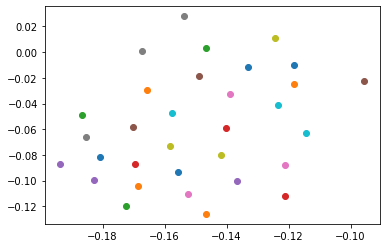

original:


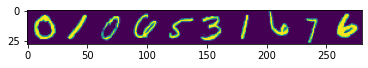

reconstructed:


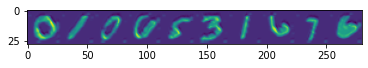

epoch: 6/20


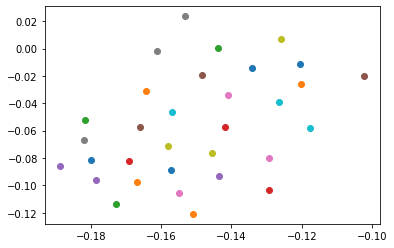

original:


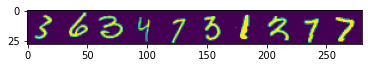

reconstructed:


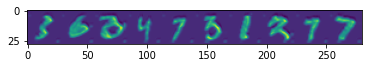

epoch: 7/20


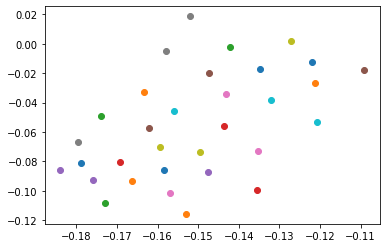

original:


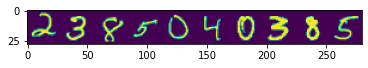

reconstructed:


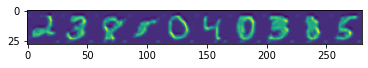

epoch: 8/20


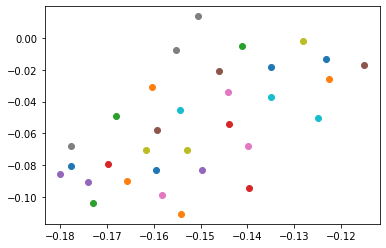

original:


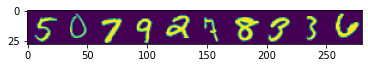

reconstructed:


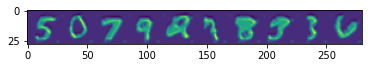

epoch: 9/20


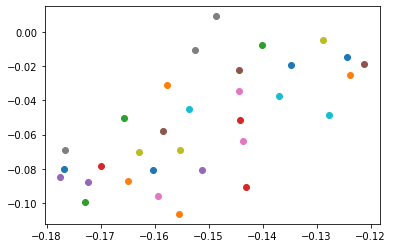

original:


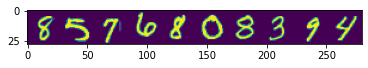

reconstructed:


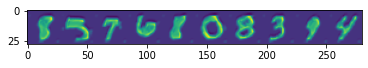

epoch: 10/20


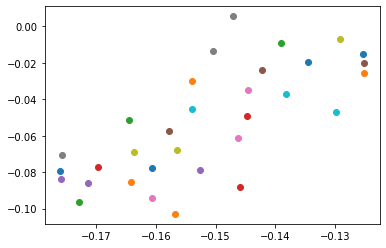

original:


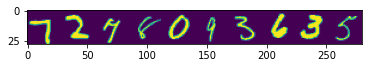

reconstructed:


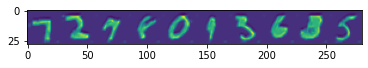

epoch: 11/20


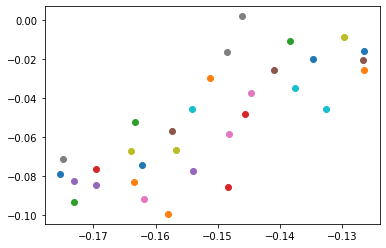

original:


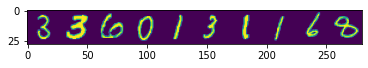

reconstructed:


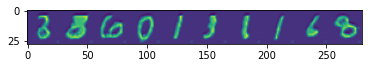

epoch: 12/20


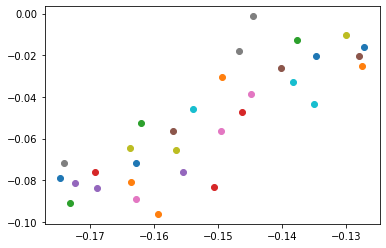

original:


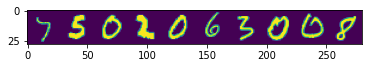

reconstructed:


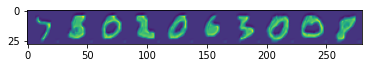

epoch: 13/20


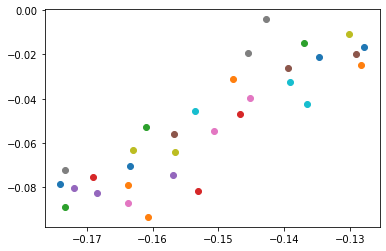

original:


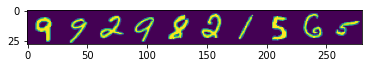

reconstructed:


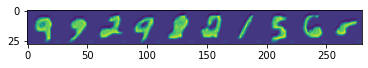

epoch: 14/20


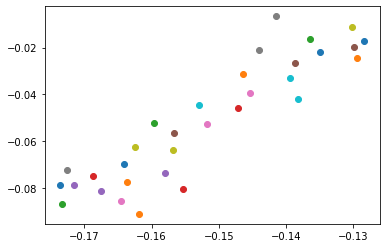

original:


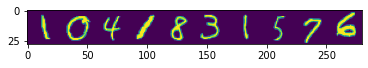

reconstructed:


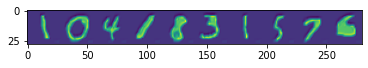

epoch: 15/20


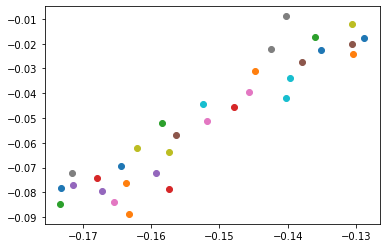

original:


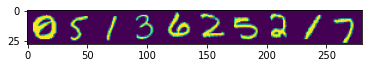

reconstructed:


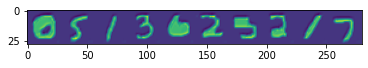

epoch: 16/20


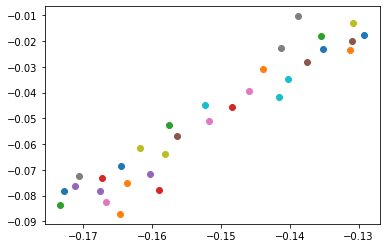

original:


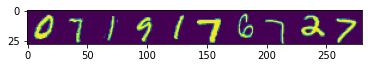

reconstructed:


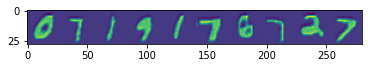

epoch: 17/20


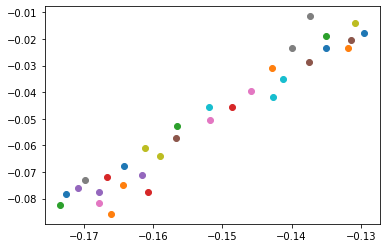

original:


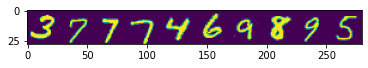

reconstructed:


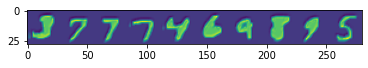

epoch: 18/20


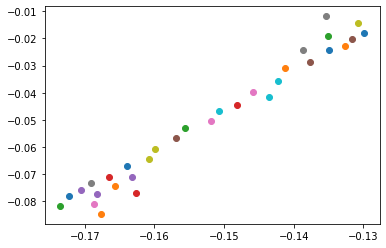

original:


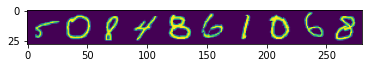

reconstructed:


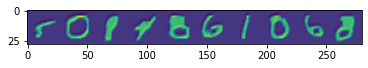

epoch: 19/20


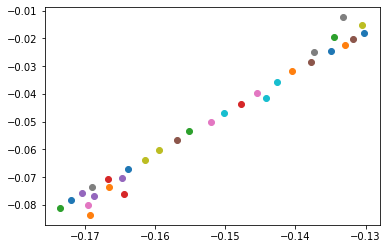

original:


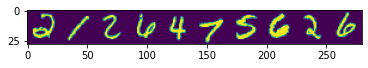

reconstructed:


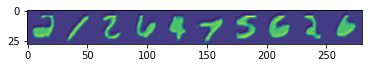

epoch: 20/20


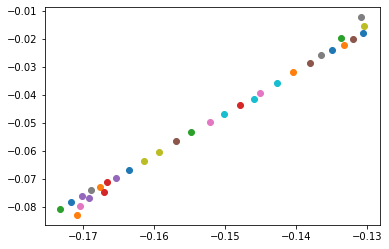

original:


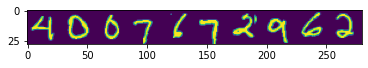

reconstructed:


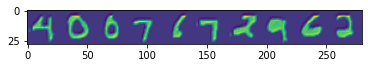

In [ ]:
vqvae_ema = VQVariationalAutoencoder(latent_dims=2, ema=True).to(device) # GPU
vqvae_ema = train(vqvae_ema, data)

epoch: 1/20


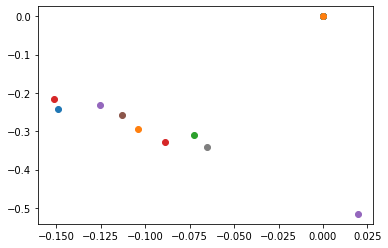

original:


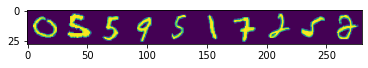

reconstructed:


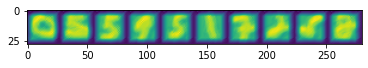

epoch: 2/20


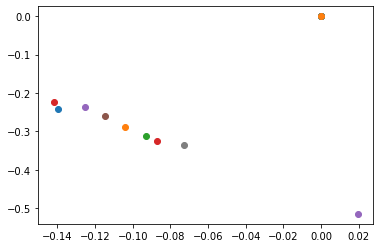

original:


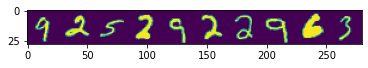

reconstructed:


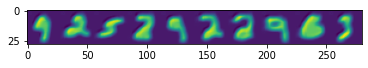

epoch: 3/20


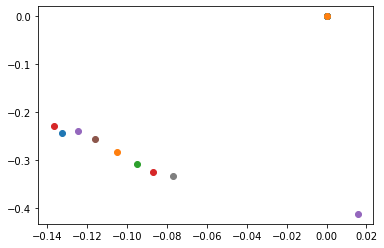

original:


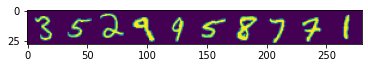

reconstructed:


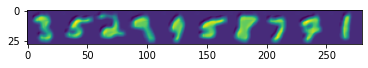

epoch: 4/20


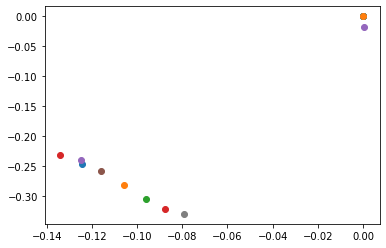

original:


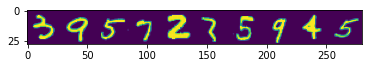

reconstructed:


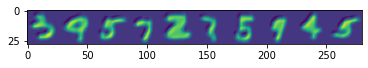

epoch: 5/20


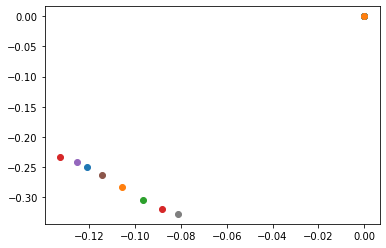

original:


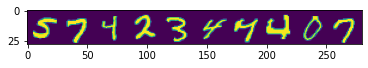

reconstructed:


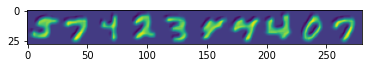

epoch: 6/20


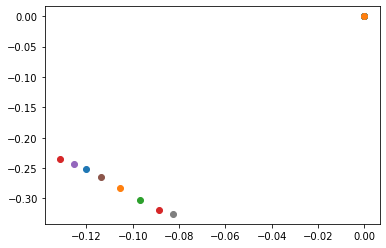

original:


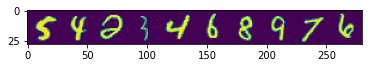

reconstructed:


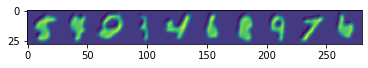

epoch: 7/20


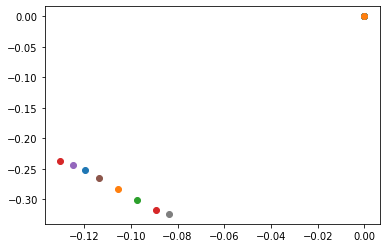

original:


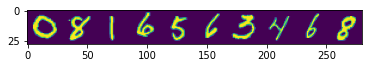

reconstructed:


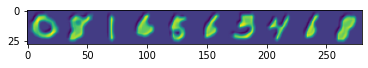

epoch: 8/20


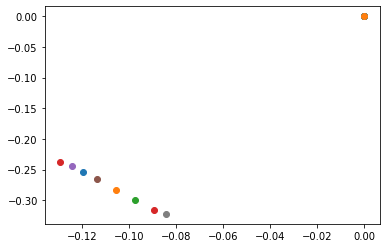

original:


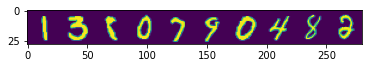

reconstructed:


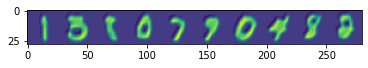

epoch: 9/20


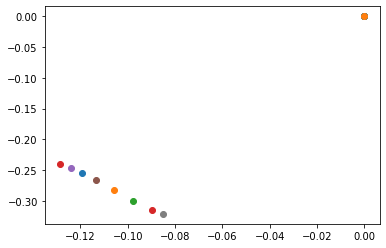

original:


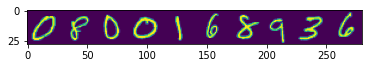

reconstructed:


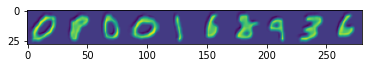

epoch: 10/20


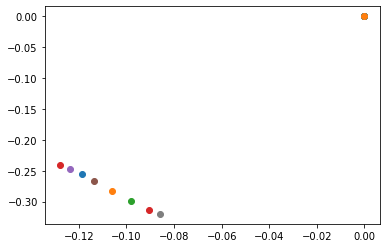

original:


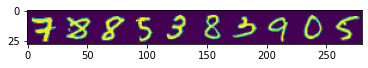

reconstructed:


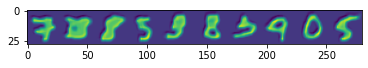

epoch: 11/20


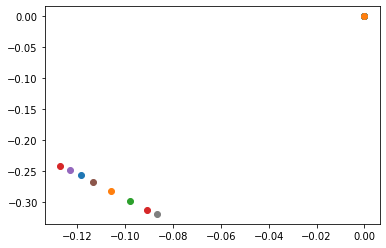

original:


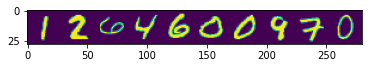

reconstructed:


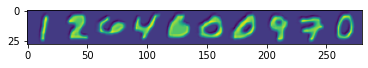

epoch: 12/20


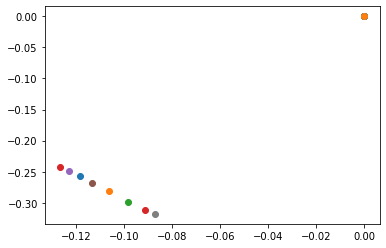

original:


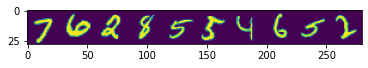

reconstructed:


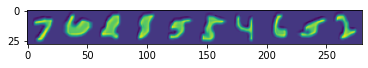

epoch: 13/20


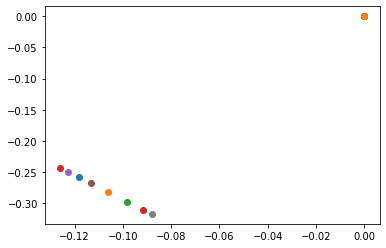

original:


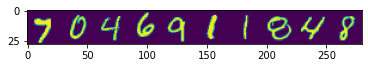

reconstructed:


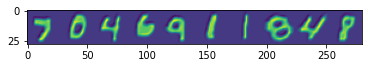

epoch: 14/20


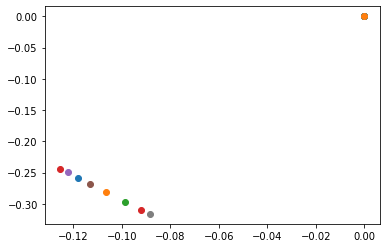

original:


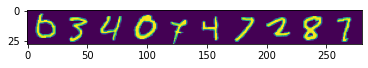

reconstructed:


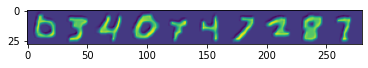

epoch: 15/20


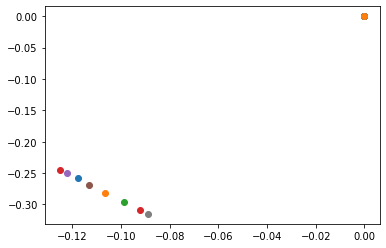

original:


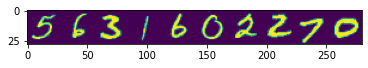

reconstructed:


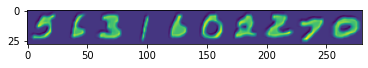

epoch: 16/20


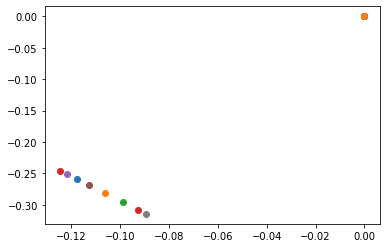

original:


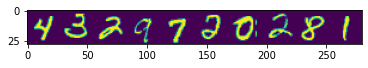

reconstructed:


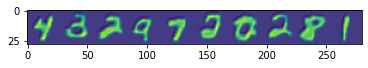

epoch: 17/20


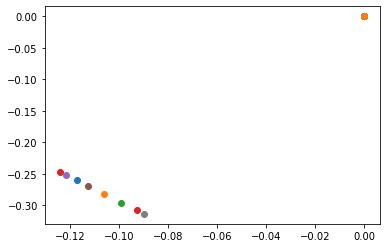

original:


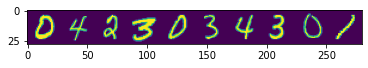

reconstructed:


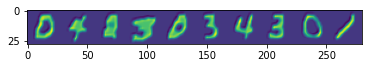

epoch: 18/20


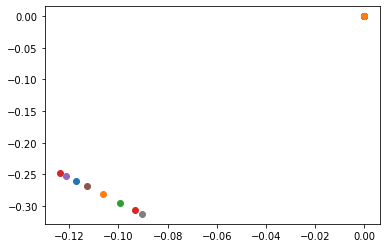

original:


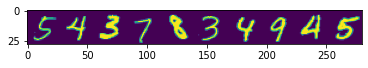

reconstructed:


epoch: 19/20


original:


reconstructed:


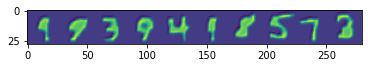

epoch: 20/20


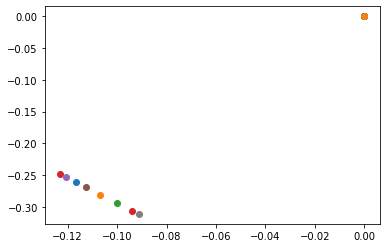

original:


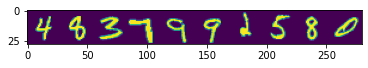

reconstructed:


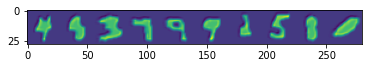

In [ ]:
vqvae_ema2 = VQVariationalAutoencoder(latent_dims=2, ema=True).to(device) # GPU
vqvae_ema2 = train(vqvae_ema2, data)

### latent_dims=32, ema=False

epoch: 1/20


original:


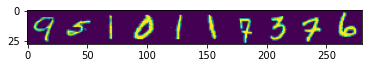

reconstructed:


epoch: 2/20


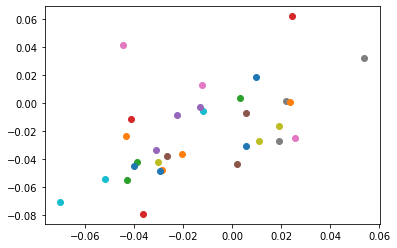

original:


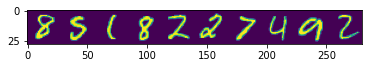

reconstructed:


epoch: 3/20


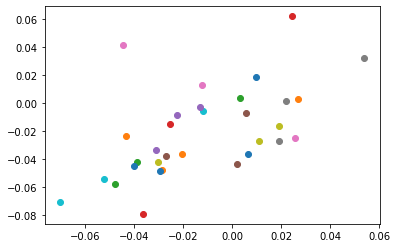

original:


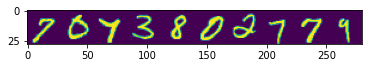

reconstructed:


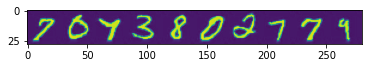

epoch: 4/20


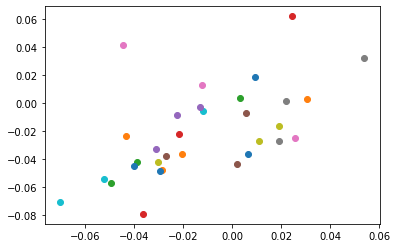

original:


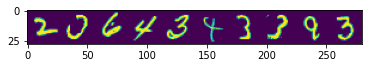

reconstructed:


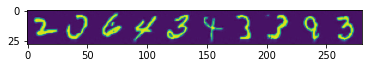

epoch: 5/20


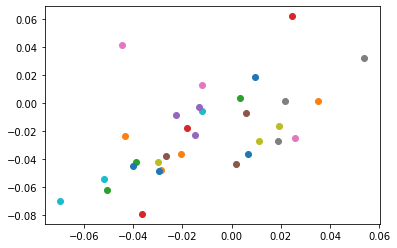

original:


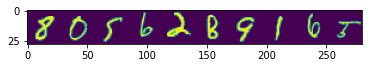

reconstructed:


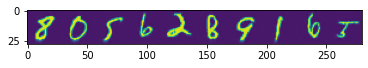

epoch: 6/20


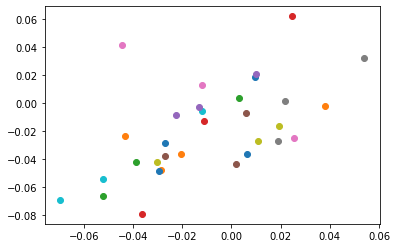

original:


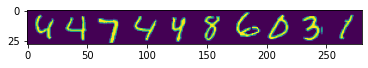

reconstructed:


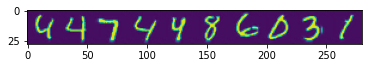

epoch: 7/20


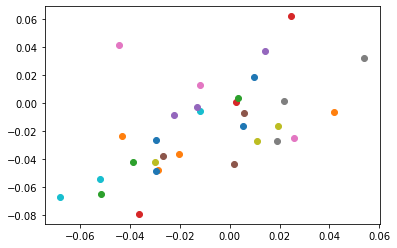

original:


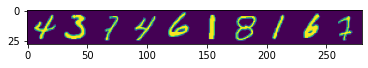

reconstructed:


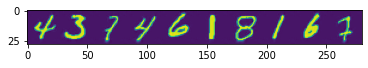

epoch: 8/20


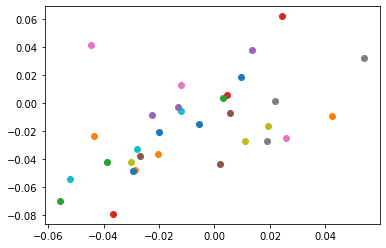

original:


reconstructed:


epoch: 9/20


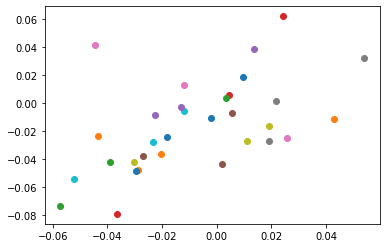

original:


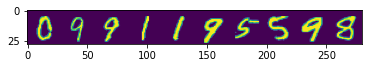

reconstructed:


epoch: 10/20


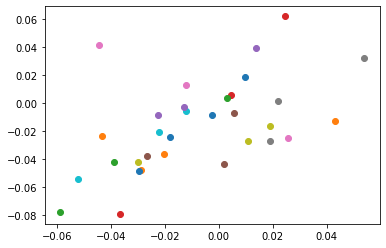

original:


reconstructed:


epoch: 11/20


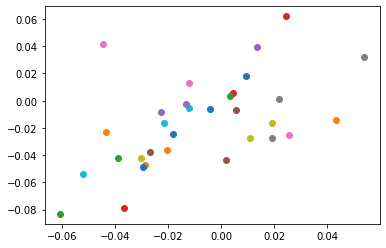

original:


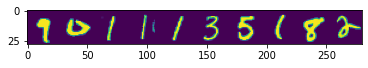

reconstructed:


epoch: 12/20


original:


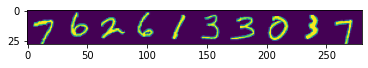

reconstructed:


epoch: 13/20


original:


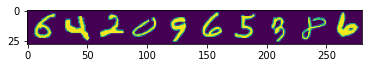

reconstructed:


epoch: 14/20


original:


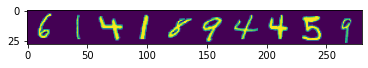

reconstructed:


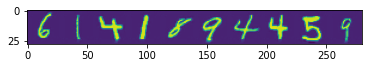

epoch: 15/20


original:


reconstructed:


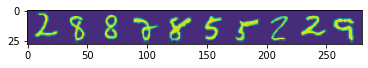

epoch: 16/20


original:


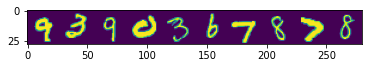

reconstructed:


epoch: 17/20


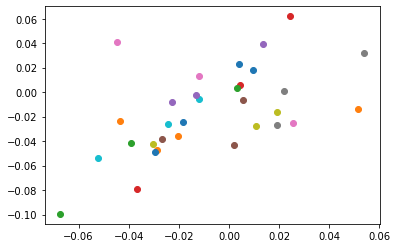

original:


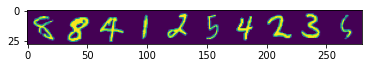

reconstructed:


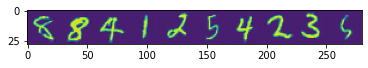

epoch: 18/20


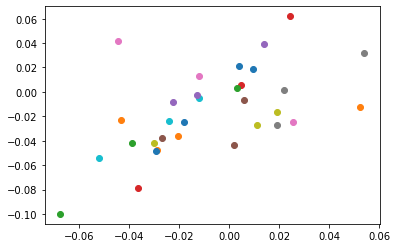

original:


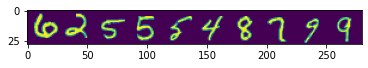

reconstructed:


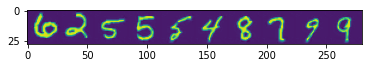

epoch: 19/20


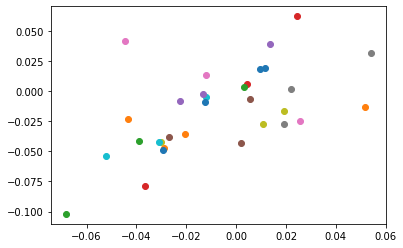

original:


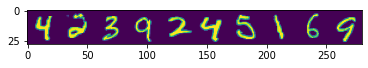

reconstructed:


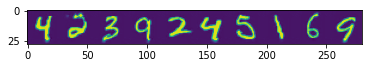

epoch: 20/20


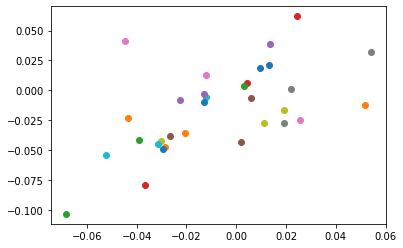

original:


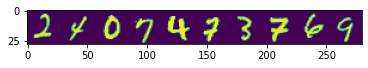

reconstructed:


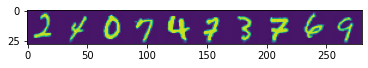

In [ ]:
vqvae2 = VQVariationalAutoencoder(latent_dims=32, ema=False).to(device) # GPU
vqvae2 = train(vqvae2, data)

### latent_dims=32, ema=True

epoch: 1/20


original:


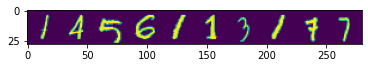

reconstructed:


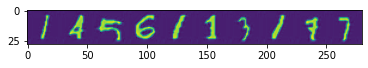

epoch: 2/20


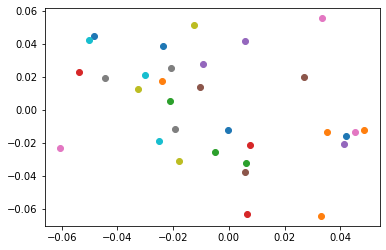

original:


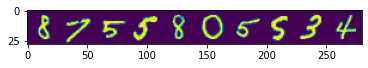

reconstructed:


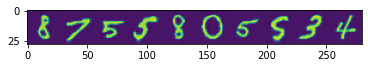

epoch: 3/20


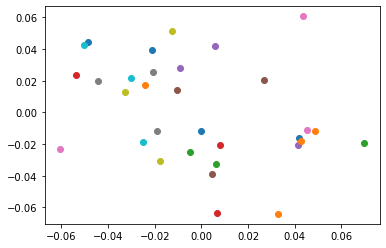

original:


reconstructed:


epoch: 4/20


original:


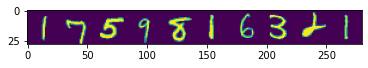

reconstructed:


epoch: 5/20


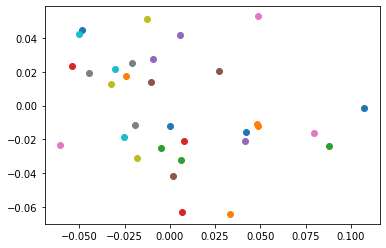

original:


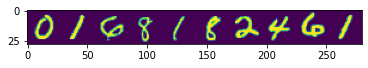

reconstructed:


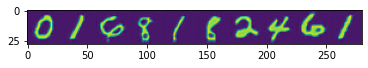

epoch: 6/20


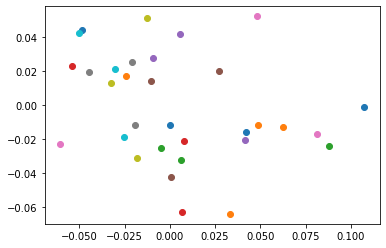

original:


reconstructed:


epoch: 7/20


original:


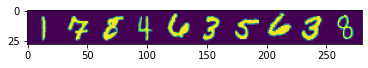

reconstructed:


epoch: 8/20


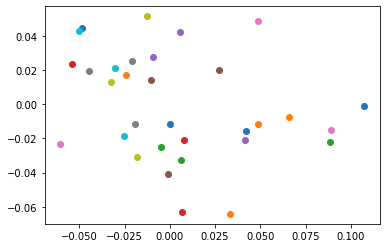

original:


reconstructed:


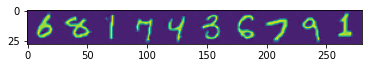

epoch: 9/20


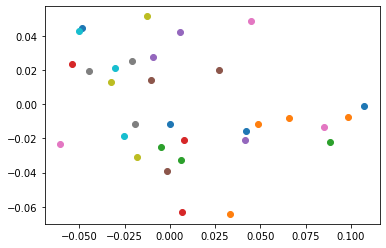

original:


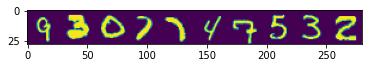

reconstructed:


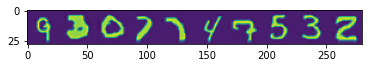

epoch: 10/20


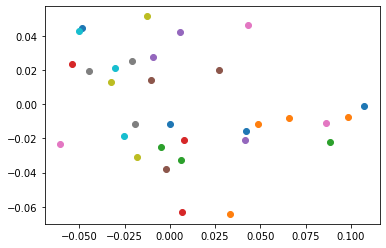

original:


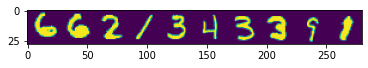

reconstructed:


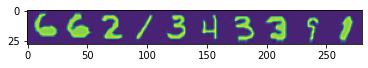

epoch: 11/20


original:


reconstructed:


epoch: 12/20


original:


reconstructed:


epoch: 13/20


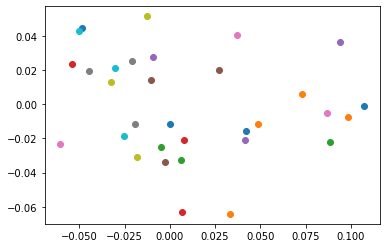

original:


reconstructed:


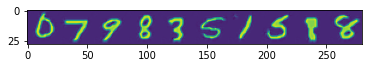

epoch: 14/20


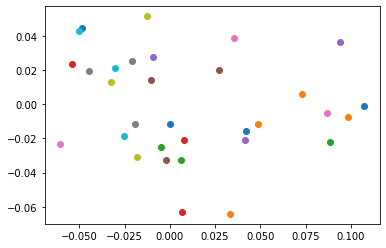

original:


reconstructed:


epoch: 15/20


original:


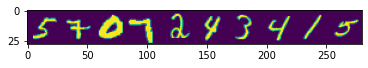

reconstructed:


epoch: 16/20


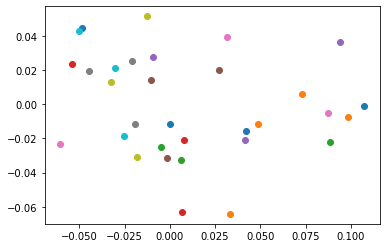

original:


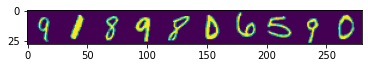

reconstructed:


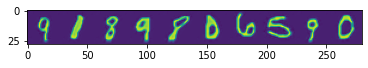

epoch: 17/20


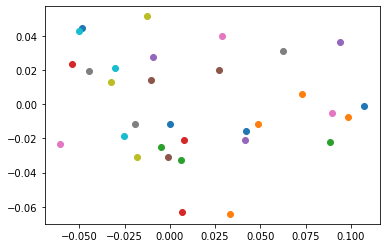

original:


reconstructed:


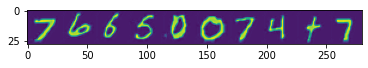

epoch: 18/20


original:


reconstructed:


epoch: 19/20


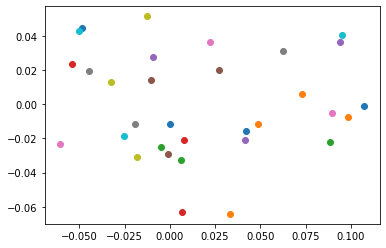

original:


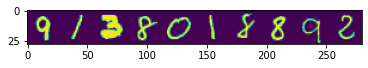

reconstructed:


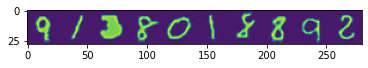

epoch: 20/20


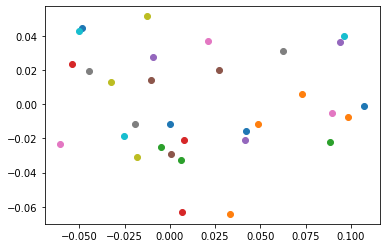

original:


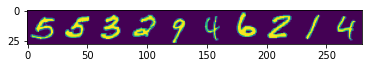

reconstructed:


In [ ]:
vqvae_ema3 = VQVariationalAutoencoder(latent_dims=32, ema=True).to(device) # GPU
vqvae_ema3 = train(vqvae_ema3, data)

# temp

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, latent_dims, num_codes=64, beta=0.025):
        super(VectorQuantizer, self).__init__()
        self.K = num_codes
        self.D = latent_dims
        self.beta = beta

        self.codebook = nn.Embedding(self.K, self.D)
        #self.codebook.weight.data.uniform_(-1 / self.K, 1 / self.K)

        self.vq_loss = 0

    def forward(self, latents):
        '''
         latents: (batch, dim)
         codebook: (K, dim)
        '''
        # Compute L2 distance between latents and codes in codebook
        dist = (latents.unsqueeze(1) - self.codebook.weight.unsqueeze(0)) ** 2 # (batch, K, dim)
        dist = dist.sum(-1) # (batch, K)

        # Get the code index that has the min distance
        nearest_idxs = torch.argmin(dist, dim=1).unsqueeze(1)  # (batch, 1)

        # Convert to one-hot
        nearest_one_hot = torch.zeros(nearest_idxs.size(0), self.K, device=latents.device) # (batch, K)
        nearest_one_hot.scatter_(1, nearest_idxs, 1)  # .scatter(dim,index,src)

        # Quantize the latents
        quantized_latents = torch.matmul(nearest_one_hot, self.codebook.weight) # (batch, K) * (K, dim) = (batch, dim)

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())

        self.vq_loss = commitment_loss * self.beta + embedding_loss
        #print("commitment_loss:",commitment_loss)
        #print("embedding_loss:",embedding_loss)

        return quantized_latents

In [ ]:
def plot_codebook_recon(autoencoder):
    codes = autoencoder.vector_quantizer.codebook.weight
    for i in range(codes.shape[0]):
        z_q = codes[i][None,:,None,None].expand(1,codes.shape[1],22,22)
        x_hat = autoencoder.decoder(z_q)
        img = x_hat.squeeze(0).squeeze(0).detach().cpu().numpy()
        plt.imshow(img)
        plt.show()

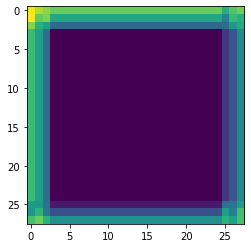

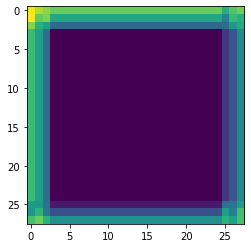

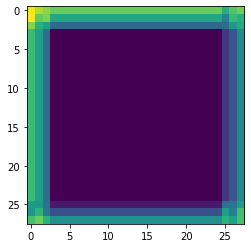

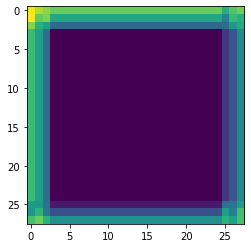

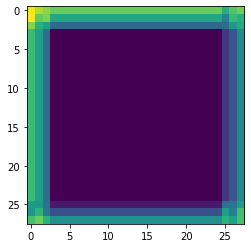

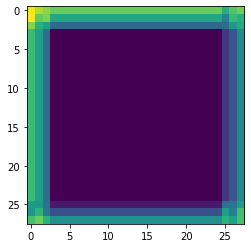

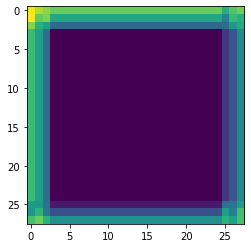

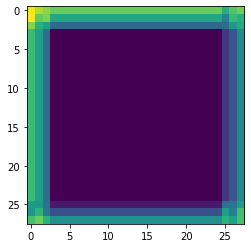

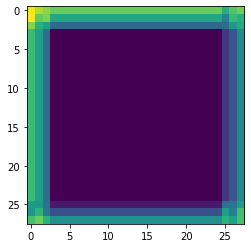

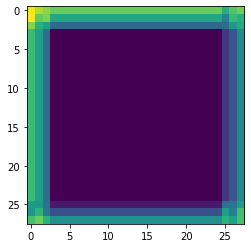

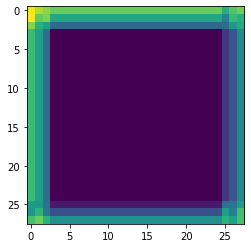

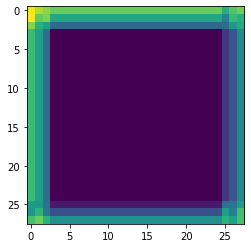

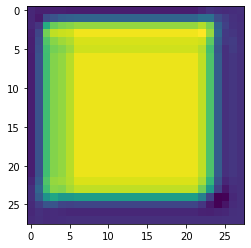

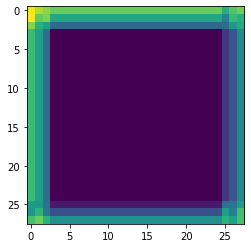

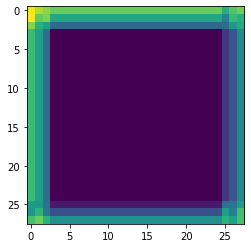

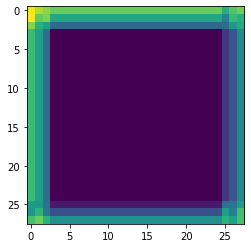

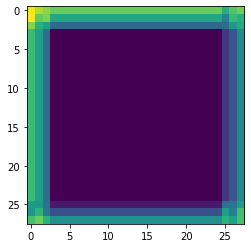

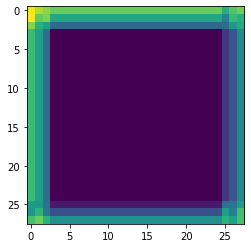

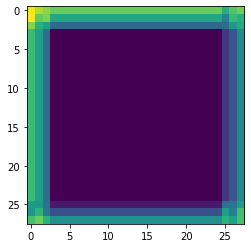

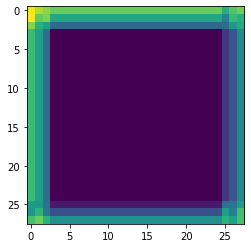

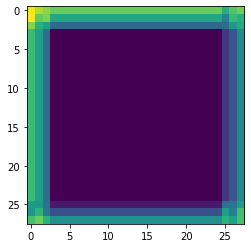

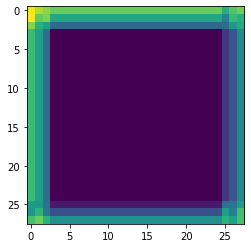

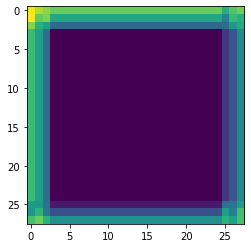

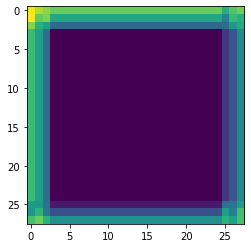

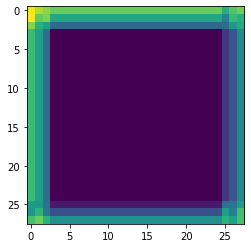

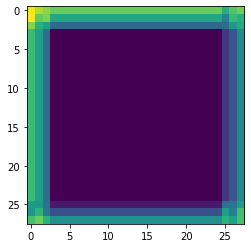

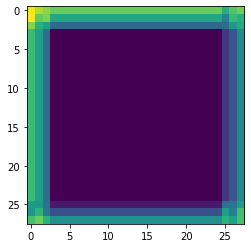

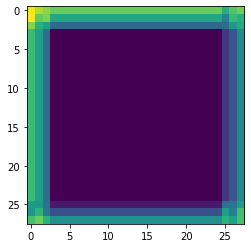

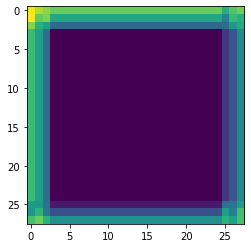

In [ ]:
plot_codebook_recon(vqvae_ema3)

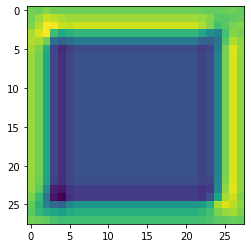

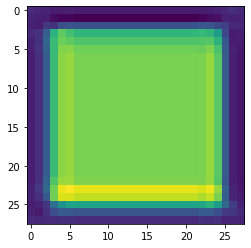

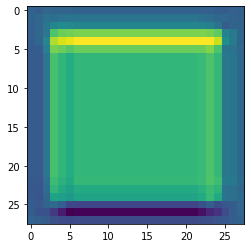

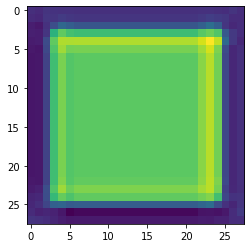

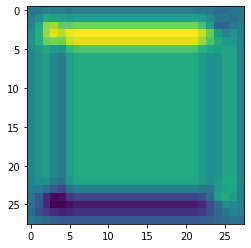

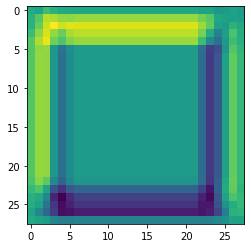

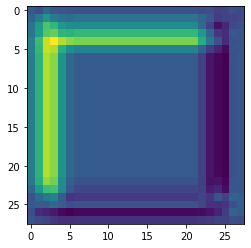

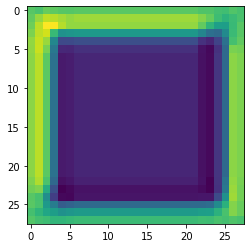

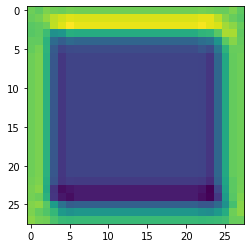

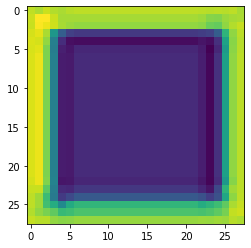

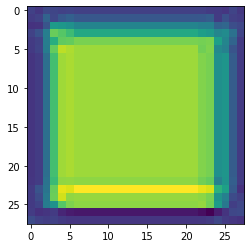

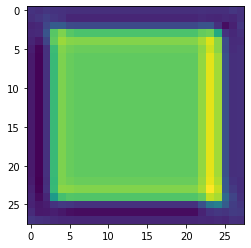

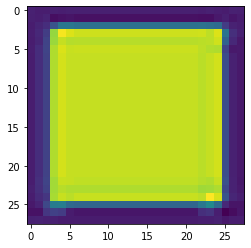

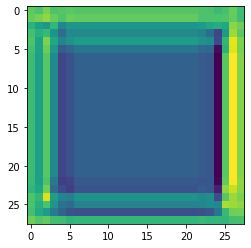

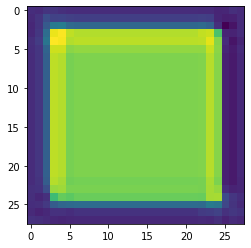

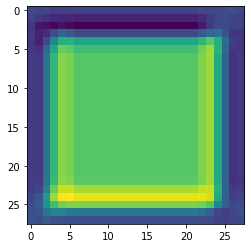

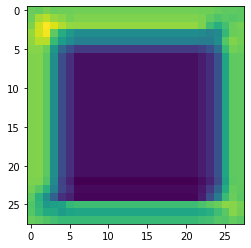

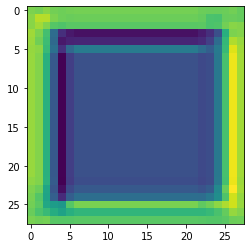

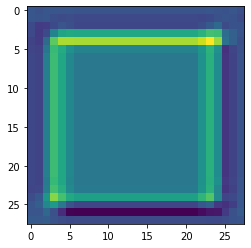

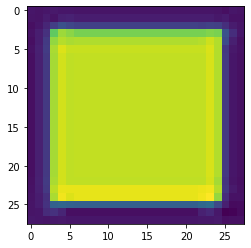

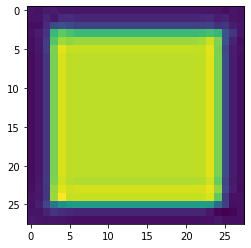

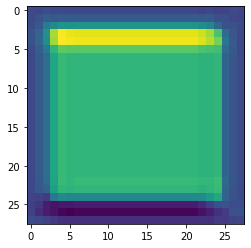

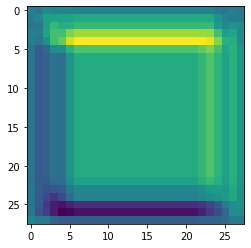

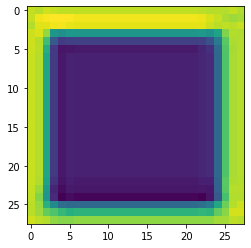

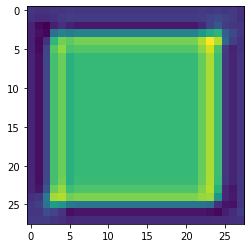

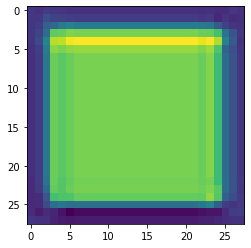

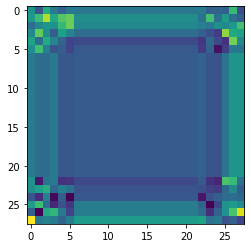

In [ ]:
plot_codebook_recon(vqvae2)

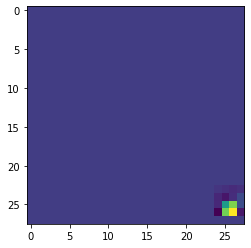

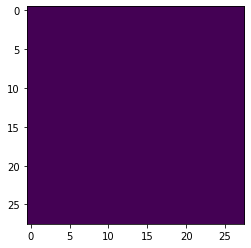

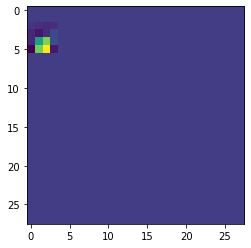

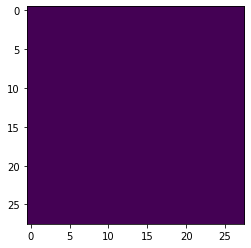

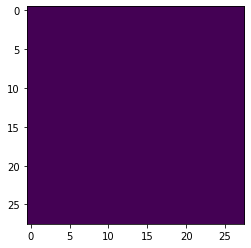

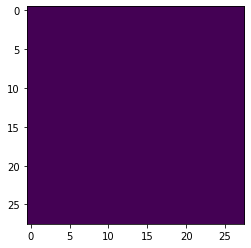

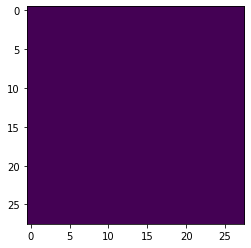

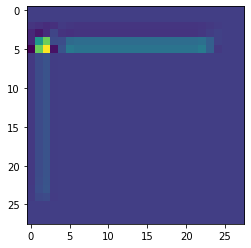

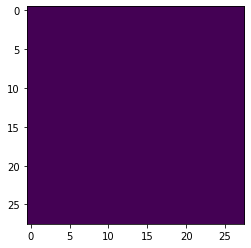

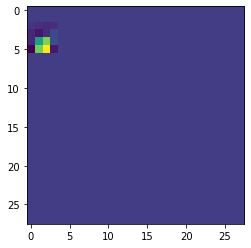

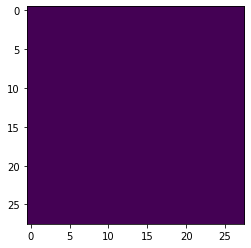

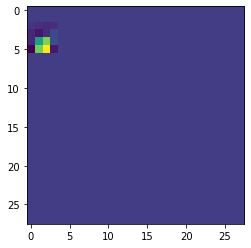

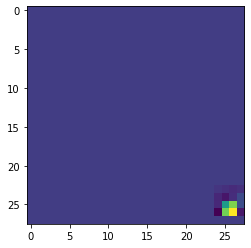

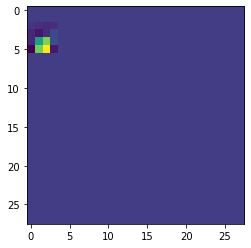

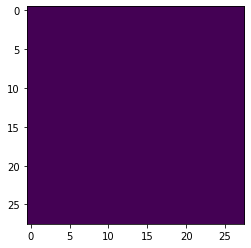

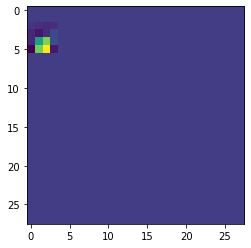

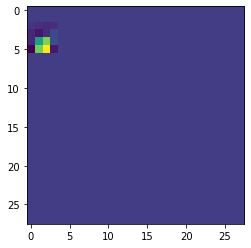

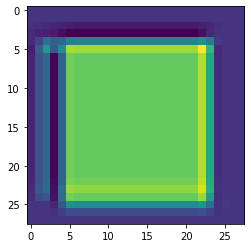

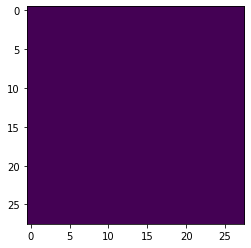

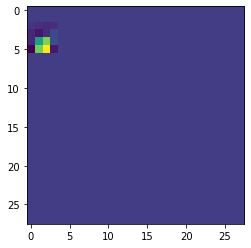

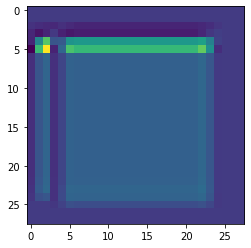

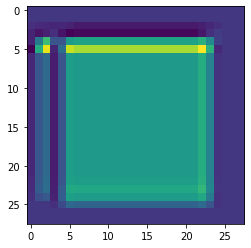

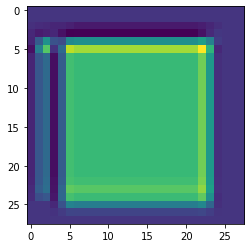

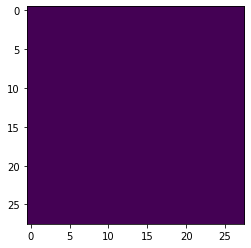

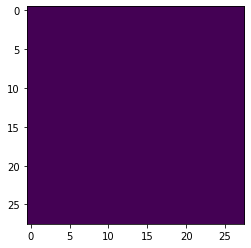

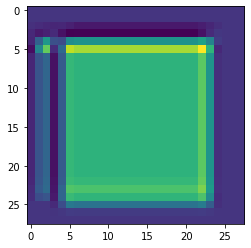

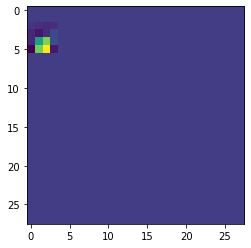

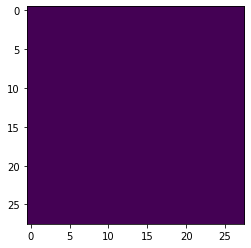

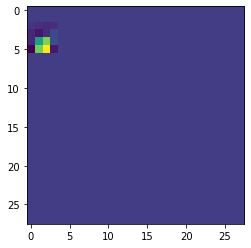

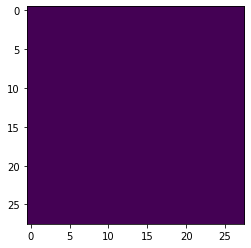

In [ ]:
plot_codebook_recon(vqvae3)